<a href="https://colab.research.google.com/github/Gotothenewsky/AI-Project/blob/main/%5BProject%202%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 라이브러리 버전

!pip install category_encoders        ## 인코더 설치
!pip install pandas-profiling==3.1.0  ## 판다스 프로파일링 설치

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#주요 라이브러리 

import pandas as pd
import numpy as np
import datetime as dt

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

# 사이킷런 - 데이터 셋 나누기
from sklearn.model_selection import train_test_split

# 사이킷런 - encoders & imputers
from category_encoders import TargetEncoder
from sklearn.impute import SimpleImputer, KNNImputer

# 사이킷런 - 파이프라인
from sklearn.pipeline import make_pipeline

# 사이킷런 - 모델 평가 지표
from sklearn.metrics import accuracy_score, mean_absolute_error, f1_score

# CV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, validation_curve


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# 자동차 관련 데이터셋 출력

train = pd.read_csv('train.csv')

target = 'Price'

In [4]:
train.isnull().sum()

ID                  0
Price               0
Levy                0
Manufacturer        0
Model               0
Prod. year          0
Category            0
Leather interior    0
Fuel type           0
Engine volume       0
Mileage             0
Cylinders           0
Gear box type       0
Drive wheels        0
Doors               0
Wheel               0
Color               0
Airbags             0
dtype: int64

In [5]:
train.dtypes

ID                    int64
Price                 int64
Levy                 object
Manufacturer         object
Model                object
Prod. year            int64
Category             object
Leather interior     object
Fuel type            object
Engine volume        object
Mileage              object
Cylinders           float64
Gear box type        object
Drive wheels         object
Doors                object
Wheel                object
Color                object
Airbags               int64
dtype: object

테스트, 훈련 데이터 순서는 다르지만 동일한 데이터 타입가짐

In [6]:
train[target].value_counts(normalize=True)

15681    0.014555
470      0.014243
14113    0.012684
392      0.012580
314      0.012216
           ...   
42601    0.000052
149      0.000052
54349    0.000052
54954    0.000052
22075    0.000052
Name: Price, Length: 2315, dtype: float64

타겟의 수가 연속적이므로 회귀문제로 다룰 예정

In [7]:
train.T.duplicated() # 중복된 행 없음.

ID                  False
Price               False
Levy                False
Manufacturer        False
Model               False
Prod. year          False
Category            False
Leather interior    False
Fuel type           False
Engine volume       False
Mileage             False
Cylinders           False
Gear box type       False
Drive wheels        False
Doors               False
Wheel               False
Color               False
Airbags             False
dtype: bool

In [8]:
train.describe(exclude='number') # categorical한 값들의 상태

,Levy,Manufacturer,Model,Category,Leather interior,Fuel type,Engine volume,Mileage,Gear box type,Drive wheels,Doors,Wheel,Color
count,19237,19237,19237,19237,19237,19237,19237,19237,19237,19237,19237,19237,19237
unique,559,65,1590,11,2,7,107,7687,4,3,3,2,16
top,-,HYUNDAI,Prius,Sedan,Yes,Petrol,2,0 km,Automatic,Front,04-May,Left wheel,Black
freq,5819,3769,1083,8736,13954,10150,3916,721,13514,12874,18332,17753,5033


In [9]:
train.describe(exclude='number').T.sort_values(by='unique') #특성 보기

,count,unique,top,freq
Leather interior,19237,2,Yes,13954
Wheel,19237,2,Left wheel,17753
Drive wheels,19237,3,Front,12874
Doors,19237,3,04-May,18332
Gear box type,19237,4,Automatic,13514
Fuel type,19237,7,Petrol,10150
Category,19237,11,Sedan,8736
Color,19237,16,Black,5033
Manufacturer,19237,65,HYUNDAI,3769
Engine volume,19237,107,2,3916


In [10]:
train['Prod. year'].value_counts() ## 특성의 범주 확인

2012    2155
2014    2124
2013    1963
2011    1612
2015    1549
2010    1483
2016    1476
2017     959
2008     737
2009     601
2018     500
2007     464
2005     402
2003     367
2004     364
2006     317
2019     306
2002     296
2000     279
2001     254
1998     213
1999     207
1997     151
1996     114
1995     105
2020      47
1994      42
1992      30
1993      23
1990      18
1988      12
1991      10
1986       6
1989       6
1987       5
1984       5
1985       5
1953       4
1983       3
1939       3
1978       2
1980       2
1965       2
1977       2
1974       2
1964       2
1943       1
1976       1
1957       1
1968       1
1947       1
1982       1
1981       1
1973       1
Name: Prod. year, dtype: int64

In [11]:
train.head(20) # 확인

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4
5,45802912,39493,891,HYUNDAI,Santa FE,2016,Jeep,Yes,Diesel,2,160931 km,4.0,Automatic,Front,04-May,Left wheel,White,4
6,45656768,1803,761,TOYOTA,Prius,2010,Hatchback,Yes,Hybrid,1.8,258909 km,4.0,Automatic,Front,04-May,Left wheel,White,12
7,45816158,549,751,HYUNDAI,Sonata,2013,Sedan,Yes,Petrol,2.4,216118 km,4.0,Automatic,Front,04-May,Left wheel,Grey,12
8,45641395,1098,394,TOYOTA,Camry,2014,Sedan,Yes,Hybrid,2.5,398069 km,4.0,Automatic,Front,04-May,Left wheel,Black,12
9,45756839,26657,-,LEXUS,RX 350,2007,Jeep,Yes,Petrol,3.5,128500 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12


In [12]:
from pandas_profiling import ProfileReport
profile = ProfileReport(train, minimal=True).to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [13]:
# 훈련/테스트 세트 모두 전처리 하기위한 함수입니다.
def clean_data(df):
    df = df.copy()
    
    ## 타겟변수의 이상치(outlier)를 제거합니다.
    df['Price'] = df[df['Price'] < np.percentile(df['Price'], 99)]['Price']
    
    ## id 변수를 제거합니다.
    df = df.drop("ID", axis = 1)

    ## 변수의 이상치를 제거합니다.
    df['Prod. year'] = df[df['Prod. year'] < np.percentile(df['Prod. year'], 99)]['Prod. year']
      
    #mileage column 에서 'km' 제거
    df['Mileage'] = pd.to_numeric(df.Mileage.str.split(' ').str[0], downcast='float')

    #mileage column 에서 0의 값을 평균으로 대체하고, 이상치 제거
    df['Mileage'] = np.where(df['Mileage'] == 0.0,df['Mileage'].mean(),df['Mileage'])
    df['Mileage'] = df[df['Mileage'] < np.percentile(df['Mileage'], 99)]['Mileage']
    df['Mileage'] = df['Mileage'].fillna(df['Mileage'].mean())

    #Doors column 변수 제거
    df['Doors'] = np.where((df['Doors'] == '04-May') | (df['Doors'] == '02-Mar'), df['Doors'].str.split('-').str[0],df['Doors'])

    #Levi column에 -를 0으로 대치
    df['Levy'] = pd.to_numeric(df['Levy'].replace('-', '0'), downcast='float')

    #Levi column에 0을 평균값으로 대치
    df['Levy'] = np.where(df['Levy'] == 0.0,df['Levy'].mean(),df['Levy'])

    #Engine volume 칼럼에 Turbo 라는 문구 삭제, 실수형으로 변환
    df['Engine volume'] = pd.to_numeric(df['Engine volume'].str.split(' ').str[0], downcast='float')

    #Engine volume 칼럼에 0값을 평균값으로 변환
    df['Engine volume']=np.where(df['Engine volume'] == 0.0,df['Engine volume'].mean(),df['Engine volume'])

    #Feature engineering the production year column
    df['Prod. year'] = df['Prod. year'].fillna(df['Prod. year'].mean())
    df = df.dropna()

    return df

In [14]:
train = clean_data(train)


In [15]:
train.dtypes

Price               float64
Levy                float32
Manufacturer         object
Model                object
Prod. year          float64
Category             object
Leather interior     object
Fuel type            object
Engine volume       float32
Mileage             float32
Cylinders           float64
Gear box type        object
Drive wheels         object
Doors                object
Wheel                object
Color                object
Airbags               int64
dtype: object

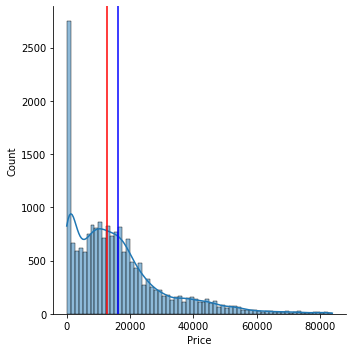

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline



## Price의 확률밀도함수를 그려보겠습니다
sns.displot(train[target], kde=True)

plt.axvline(train[target].mean(), color='blue')
plt.axvline(train[target].median(), color='red');

타겟변수가 Left(Positively) Skewed 양상을 보임

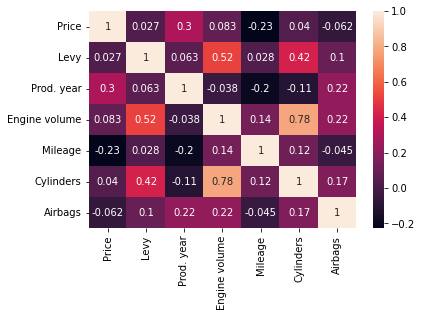

In [17]:
# heatmap을 통한 데이터의 상관관계 확인
sns.heatmap(train.corr(), cbar=True, annot=True)

가격과 크게 상관있는 연속형 변수는 보이지 않음

대신 Levy, Engine volume, Cylinders 사이에 상관간계가 강한 것이 보임

연속형 변수와 Target값인 'Price'와 상관관계가 크지 않으므로 타겟의 평균값이 기준 모델이 되야함

In [18]:
from sklearn.metrics import classification_report

In [19]:
from sklearn.model_selection import train_test_split

# 80/20 비율로 학습/테스트 데이터를 분리합니다.
train, test = train_test_split(train, test_size=0.2, random_state=42)
                              
X_train = train.drop(columns=target)
y_train = train[target]
X_test = test.drop(columns=target)
y_test = test[target]

In [20]:
train.shape, test.shape, X_train.shape, y_train.shape, X_test.shape, y_test.shape

((15232, 17), (3809, 17), (15232, 16), (15232,), (3809, 16), (3809,))

In [21]:
y_test.head()

15404    21639.0
10302    10976.0
4790     18660.0
329       7840.0
15815    12720.0
Name: Price, dtype: float64

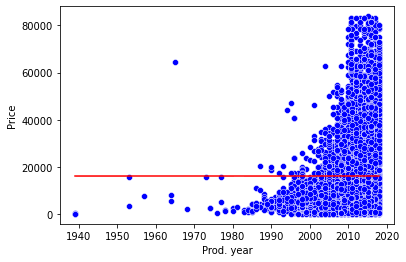

In [22]:
# 기준모델로 훈련 에러(MAE) 계산

x = train['Prod. year']
y = train['Price']

predict = train['Price'].mean()
errors = predict - train['Price']
mean_absolute_error = errors.abs().mean()

sns.lineplot(x=x, y=predict, color='red')
sns.scatterplot(x=x, y=y, color='blue');

In [23]:
print(f'예측한 가격이 ${predict:,.0f}이며 절대평균에러가 ${mean_absolute_error:,.0f}임을 확인할 수 있습니다.')

예측한 가격이 $16,048이며 절대평균에러가 $10,975임을 확인할 수 있습니다.


In [24]:
X_train.head(20)

,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
2026,891.000000,HYUNDAI,Sonata,2016.000000,Sedan,Yes,Petrol,2.0,112161.00000,4.0,Automatic,Front,04,Left wheel,White,4
1302,632.528687,LINCOLN,Town Car,2000.000000,Limousine,Yes,Petrol,4.6,100000.00000,8.0,Automatic,Rear,04,Left wheel,White,8
12084,607.000000,TOYOTA,Camry,2010.759161,Sedan,Yes,Hybrid,2.5,39552.00000,4.0,Automatic,Front,04,Left wheel,Black,12
12238,632.528687,OPEL,Astra,2002.000000,Goods wagon,No,Diesel,2.0,237700.00000,4.0,Manual,Front,04,Left wheel,Grey,5
18255,632.528687,TOYOTA,Prius,2015.000000,Hatchback,No,Hybrid,1.8,26000.00000,4.0,Automatic,Front,04,Left wheel,Grey,10
9967,632.528687,TOYOTA,Aqua,2013.000000,Hatchback,Yes,Petrol,1.5,139000.00000,4.0,Automatic,Front,04,Left wheel,Silver,12
8342,640.000000,HYUNDAI,Santa FE,2013.000000,Jeep,Yes,Diesel,2.0,190000.00000,4.0,Automatic,Front,04,Left wheel,Grey,4
18979,585.000000,HYUNDAI,Elantra,2013.000000,Sedan,Yes,Petrol,1.8,142224.00000,4.0,Automatic,Front,04,Left wheel,Grey,12
18508,586.000000,TOYOTA,Prius,2012.000000,Hatchback,No,Hybrid,1.8,212000.00000,4.0,Variator,Front,04,Left wheel,Black,9
1711,632.528687,MERCEDES-BENZ,E 550,2006.000000,Sedan,Yes,LPG,5.5,134000.00000,8.0,Tiptronic,Rear,04,Left wheel,Black,8


In [25]:
X_train.isnull().sum()

Levy                0
Manufacturer        0
Model               0
Prod. year          0
Category            0
Leather interior    0
Fuel type           0
Engine volume       0
Mileage             0
Cylinders           0
Gear box type       0
Drive wheels        0
Doors               0
Wheel               0
Color               0
Airbags             0
dtype: int64

In [26]:
# 훈련/테스트 세트 모두 전처리 하기위한 함수입니다.
def clean_data2(df):
    df = df.copy()
    
    ## 컬럼을 제거합니다.
    ## id 변수를 제거합니다.
    df = df.drop("Levy", axis =1)
    df = df.drop("Prod. year", axis =1 )
    df = df.drop("Mileage", axis =1 )

    return df

In [27]:
train = clean_data2(train)
X_train = clean_data2(X_train)
X_test = clean_data2(X_test)

In [28]:
train.head(20)

,Price,Manufacturer,Model,Category,Leather interior,Fuel type,Engine volume,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
2026,21326.0,HYUNDAI,Sonata,Sedan,Yes,Petrol,2.0,4.0,Automatic,Front,04,Left wheel,White,4
1302,150.0,LINCOLN,Town Car,Limousine,Yes,Petrol,4.6,8.0,Automatic,Rear,04,Left wheel,White,8
12084,251.0,TOYOTA,Camry,Sedan,Yes,Hybrid,2.5,4.0,Automatic,Front,04,Left wheel,Black,12
12238,8467.0,OPEL,Astra,Goods wagon,No,Diesel,2.0,4.0,Manual,Front,04,Left wheel,Grey,5
18255,31361.0,TOYOTA,Prius,Hatchback,No,Hybrid,1.8,4.0,Automatic,Front,04,Left wheel,Grey,10
9967,14113.0,TOYOTA,Aqua,Hatchback,Yes,Petrol,1.5,4.0,Automatic,Front,04,Left wheel,Silver,12
8342,35962.0,HYUNDAI,Santa FE,Jeep,Yes,Diesel,2.0,4.0,Automatic,Front,04,Left wheel,Grey,4
18979,549.0,HYUNDAI,Elantra,Sedan,Yes,Petrol,1.8,4.0,Automatic,Front,04,Left wheel,Grey,12
18508,15994.0,TOYOTA,Prius,Hatchback,No,Hybrid,1.8,4.0,Variator,Front,04,Left wheel,Black,9
1711,27284.0,MERCEDES-BENZ,E 550,Sedan,Yes,LPG,5.5,8.0,Tiptronic,Rear,04,Left wheel,Black,8


In [29]:
# import
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_log_error

# ordinal encoding
from category_encoders import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer 
from sklearn.pipeline import make_pipeline

In [31]:
from xgboost import XGBClassifier
from category_encoders import OrdinalEncoder

pipe = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    XGBClassifier(n_estimators=200
                  , random_state=2
                  , n_jobs=-1
                  , max_depth=7
                  , learning_rate=0.1
                 )
)

pipe.fit(X_train, y_train);

In [32]:
print('검증세트 정확도', pipe.score(X_test, y_test))

검증세트 정확도 0.1320556576529273


In [ ]:
y_predict=pipe.predict(X_test)
RMLSE=np.sqrt(mean_squared_log_error(np.exp(y_test),np.exp(y_predict)))

In [ ]:
pipe_importance = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(), 
    RandomForestClassifier(n_estimators=100, random_state=2, n_jobs=-1)
)

pipe_importance

In [ ]:
# 특성 중요도
rf = pipe_importance.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

%matplotlib inline
import matplotlib.pyplot as plt

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh();

In [ ]:
!pip install pdpbox

from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 144

In [ ]:
enc = OrdinalEncoder(handle_missing="value")
X_train, y_train = enc.fit(X_train, y_train)

In [ ]:
#랜덤서치CV 최적파라미터 찾기

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 800, num = 8)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
min_samples_split = [2, 5, 10, 15]
min_samples_leaf = [1, 2, 5]

In [ ]:
# random grid 찾기
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

print(random_grid)

In [ ]:
rf_model = RandomForestRegressor()

In [ ]:
rf_random_model = RandomizedSearchCV(estimator = rf_model, param_distributions = 
                                     random_grid,scoring='neg_mean_squared_error', 
                                     n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs = 1
                                     )

In [ ]:
rf_random_model.fit(X_train,y_train)

In [ ]:
rf_random_model.best_params_

In [ ]:
model1 = pipe_importance.fit(X_train, y_train)

In [ ]:
y_pred=pipe_importance.predict(X_test)

In [ ]:
RMLSE1=np.sqrt(mean_squared_log_error(np.exp(y_test),np.exp(y_pred)))

In [ ]:
RMLSE1